In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import IPython
from mpl_toolkits.axes_grid1 import make_axes_locatable
from misc import reportProgress
from scipy.ndimage.filters import gaussian_filter
from misc import round_sig_str as round_sig_str
import misc
import GaussianFilter as gf
import minBlur as mb
import MarksConstants as mc
from importlib import reload

In [2]:
QE = 0.9
darkElectronChance = 0.0003
seed = random.randint(1,70)
rs = np.random.RandomState(seed)
size = 50
#center of array
p0=int(size/2)
h_pixelsInBin = 2
v_pixelsInBin = 2
zTotalSize = 5e-6

In [3]:
def reportProgress(num, total):
    print( round_sig_str(num/total*100) + '%                     ',  end='\r' )
    IPython.display.clear_output(wait=True)

In [4]:
def XYZ_Blur(input3D, zTotalSize = 5e-6, zDepBlur = True, xyDepBlur = True, fovSize = 20e-6):
    """
    zTotalSize is the z direction length in meters.
    """
    fsill = 0.0156
    all2DSlices = [input3D[i] for i in range(0,size)]
    blurrySlicesGausTest = []
    dz = np.linspace(-zTotalSize/2, zTotalSize/2, size)
   
    for j in range(0,len(all2DSlices)):
        if zDepBlur:
            zBlurredAmount = mb.minBlur(dz[j]+fsill)
        else:
            zBlurredAmount = mb.minBlur(fsill)
        reportProgress(j, len(all2DSlices))
            
        xyzBlurrySlice = gf.gaussianFilter(all2DSlices[j], zBlurredAmount, 20e-6, xyDepBlur, fovSize)
                    
        blurrySlicesGausTest.append(xyzBlurrySlice)

    blurrySlicesSum = sum(blurrySlicesGausTest)
    
    return blurrySlicesSum

In [5]:
with open('2dExcitedStateExpansion.csv','rb') as datafile:
    images_f = datafile.readlines()

In [6]:
imageArray = []
for imageStr in images_f:
    imageListStr = imageStr.split(b',')
    imageList = [float(dp) for dp in imageListStr[:-1]]
    imageArray.append(np.reshape(imageList,(1000,1000)))

In [7]:
array3D = np.zeros((50,1000,1000))
dzPos = np.linspace(-zTotalSize/2, zTotalSize/2, num=50)
xySlice = imageArray[49]

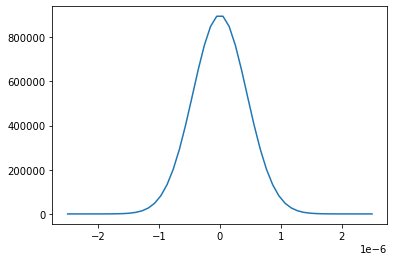

In [8]:
def zGaussian(time, z):
    sigma_x_0 = np.sqrt(mc.hbar/(mc.Rb87_M*2*np.pi*35e3))
    sigma_v = np.sqrt(mc.hbar*np.pi*35e3/mc.Rb87_M)
    sigma  = np.sqrt(sigma_v**2*(time*1e-6)**2 + sigma_x_0**2)
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(z)**2/(2*sigma**2))
plt.plot(dzPos, zGaussian(49, dzPos))

In [9]:
wavefunctionSlices= []
for i, zSlice in enumerate(array3D):
    zSlice = xySlice*zGaussian(49, dzPos[i])
    wavefunctionSlices.append(zSlice)
#print(wavefunctionSlices)
wavefunctionSlices = np.array(wavefunctionSlices)

In [10]:
def softwareBinning(binningParams, rawData):
    if binningParams is not None:
        sb = binningParams
        if len(np.array(rawData).shape) == 3: 
            if not ((rawData.shape[1]/sb[0]).is_integer()): 
                raise ValueError('Vertical size ' + str(rawData.shape[1]) +  ' not divisible by binning parameter ' + str(sb[0]))
            if not ((rawData.shape[2]/sb[1]).is_integer()):
                raise ValueError('Horizontal size ' + str(rawData.shape[2]) +  ' not divisible by binning parameter ' + str(sb[1]))
            rawData = rawData.reshape(rawData.shape[0], rawData.shape[1]//sb[0], sb[0], rawData.shape[2]//sb[1], sb[1]).sum(4).sum(2)
        elif len(np.array(rawData).shape) == 2:
            if not ((rawData.shape[0]/sb[0]).is_integer()): 
                raise ValueError('Vertical size ' + str(rawData.shape[0]) +  ' not divisible by binning parameter ' + str(sb[0]))
            if not ((rawData.shape[1]/sb[1]).is_integer()):
                raise ValueError('Horizontal size ' + str(rawData.shape[1]) +  ' not divisible by binning parameter ' + str(sb[1]))
            rawData = rawData.reshape(rawData.shape[0]//sb[0], sb[0], rawData.shape[1]//sb[1], sb[1]).sum(3).sum(1)
        else:
            raise ValueError('Raw data must either 2 or 3 dimensions')            
    return rawData

In [11]:
binnedwvftn = softwareBinning([20,20], wavefunctionSlices)
print(binnedwvftn.shape)

(50, 50, 50)


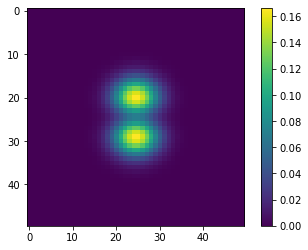

In [12]:
blurredwvftn = XYZ_Blur(binnedwvftn)*2e9
plt.imshow(blurredwvftn)
plt.colorbar()

In [13]:
for rowi, row in enumerate(blurredwvftn):
    for coli, col in enumerate(row):
        meanIntensity = blurredwvftn[rowi, coli]
        #print(meanIntensity)

In [14]:
x = np.arange(1000)

def gain(x): 
    return np.exp(-0.009*x)

gain_pdf=gain(x)

#print(np.random.choice(x, p=gain_pdf/sum(gain_pdf)))

In [15]:
def bins(originalImage, pixelsInBin):
    binned = []
    for rowi, row in enumerate(originalImage):
        for coli in range(0, len(row), pixelsInBin):
            binned.append(singleBinH(originalImage, rowi, coli, pixelsInBin))
        

    floats = [float(m) for m in binned]
    binning = np.reshape(floats, (originalImage.shape[0],int(originalImage.shape[1]/pixelsInBin))) 
    
    return binning

In [16]:
def bin2D(originalImage, hPixelsInBin, vPixelsInBin):
    
    #12x15
    #hbinning=3, vbinning = 4
    #result: 3x5
    
    hBinnedImage = bins(originalImage, hPixelsInBin)
    #print(hBinnedImage.shape, 'h')
    #12x5
    transposed = np.array(misc.transpose(hBinnedImage))
    #print(transposed.shape, 't')
    #5x12
    vBinnedImage = bins(transposed, vPixelsInBin)
    #print(vBinnedImage.shape, 'v')
    #5x3
    bothBinned = np.array(misc.transpose(vBinnedImage))
    #print(bothBinned.shape, 'f')
    
    return bothBinned 

In [17]:
def singleBinH(originalImage, rowi, coli, pixelsInBin): 
    return sum(originalImage[rowi, coli:coli+pixelsInBin])

In [18]:
def getSimulatedImage():
    
    
    image = np.zeros((size, size))
    photonImage = np.zeros((size, size))
    blurred = np.zeros((size,size))
    newImage = np.zeros((int(size/h_pixelsInBin), int(size/v_pixelsInBin)))
            
    #This loop applies Poisson-distributed shotnoise.        
    for rowi, row in enumerate(image):
        for coli, col in enumerate(row):
            #sample from blurred gaussian
            meanIntensity = blurredwvftn[rowi, coli]
            shotnoise = rs.poisson(meanIntensity)
            photonImage[rowi, coli] += shotnoise
            
    #Calculate number of electrons accounting for QE, dark electrons, EM gain noise, and readout noise.
    for rowi, row in enumerate(image):
        for coli, col in enumerate(row):
            numPhotons = photonImage[rowi, coli]
            numElectrons = numPhotons*QE
            #random chance to find a "Dark electron"           
            if np.random.random() < darkElectronChance:
                numElectrons += 1    
                
           # photonImage[rowi, coli] +=numElectrons
                
 
        #EM gain amplification: using 1 distribution, sampling from it as many times as there are electrons on a pixel.
            if numElectrons == 0:
                electronsGained = 0
            elif numElectrons == 1:
                ElectronsOut = np.random.choice(x, p=gain_pdf/sum(gain_pdf))
                electronsGained = ElectronsOut
            else:
                ElectronsOut = np.random.choice(x, size=int(numElectrons), p=gain_pdf/sum(gain_pdf))
                electronsGained = sum(ElectronsOut)
            photonImage[rowi, coli] += electronsGained
            previousNoise = photonImage[rowi, coli]
 #camera binning in 2D
    h_v_binned = bin2D(photonImage, h_pixelsInBin, v_pixelsInBin)   
    for rowi, row in enumerate(h_v_binned):
        for coli, col in enumerate(row):   
            
            readOutNoise = np.random.randint(0, 20)
            #counts = readOutNoise

            h_v_binned[rowi, coli] += readOutNoise
            
    return h_v_binned

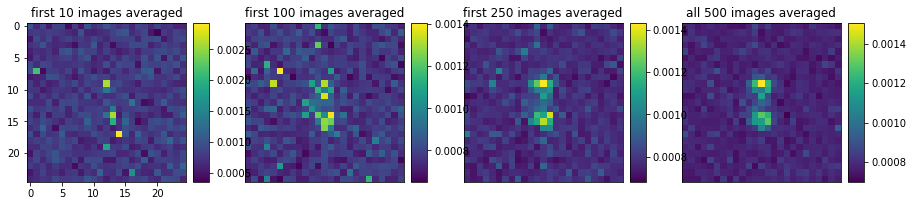

In [19]:
imageSeries = []

for imageNum in range(500):
    imageSeries.append(getSimulatedImage())
    reportProgress(imageNum, 500)

avgImage3 = np.mean(imageSeries [:10], 0)
avgImage25 = np.mean(imageSeries [:100], 0)
avgImage50 = np.mean(imageSeries [:250], 0)
avgImage = np.mean(imageSeries,0)


normalizedImage3 = avgImage3/(111**2)
normalizedImage25 = avgImage25/(111**2)
normalizedImage50 = avgImage50/(111**2)
normalizedImage = avgImage/(111**2)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=[15, 15])

img0 = ax0.imshow(normalizedImage3)
ax0.set_title('first 10 images averaged')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb0 = plt.colorbar(img0, cax=cax)

img1 = ax1.imshow(normalizedImage25)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('first 100 images averaged')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb = plt.colorbar(img1, cax=cax)

img2 = ax2.imshow(normalizedImage50)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('first 250 images averaged')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb = plt.colorbar(img2, cax=cax)

img3 = ax3.imshow(normalizedImage)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('all 500 images averaged')

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="10%", pad=0.10)
cb = plt.colorbar(img3, cax=cax)

plt.show()
